1. embed corpus.
2. Find most similar use of the word in a corpus
3. Test if mean pooling one word across all documents returns anything meaningful.

In [122]:
import torch
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset

In [123]:
def get_embedding(text, embedding_type="document", word=None, doc_pooling="cls", word_pooling="mean", model_name = "mlburnham/Political_DEBATE_base_v1.0"):
    """
    Get embeddings for a single document or a list of documents.

    Args:
        text (str or list): The input text (a single document or a list of documents).
        embedding_type (str): Type of embedding. Options: "document" (default) or "word".
        word (str): The word to get the embedding for (required if embedding_type="word").
        doc_pooling (str): Pooling method for document embeddings. Options: "cls" (default) or "mean".
        word_pooling (str): Pooling method for word embeddings. Options: "mean", "max", "sum", "min".

    Returns:
        torch.Tensor or list: The embedding(s) for the document(s).
    """
    # Handle single document input
    if isinstance(text, str):
        texts = [text]
    elif isinstance(text, list):
        texts = text
    else:
        raise ValueError("Input 'text' must be a string or a list of strings.")

    # Initialize the model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    # pass the model to the device
    model.to(device)
    
    embeddings = []
    for doc in texts:
        # Tokenize the input text
        inputs = tokenizer(doc, return_tensors="pt", padding=False, truncation=True, max_length=512).to(device)

        # Get the embeddings from the model
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Get the token embeddings (last hidden state)
        token_embeddings = outputs.last_hidden_state  # Shape: (batch_size, sequence_length, hidden_size)
        
        if embedding_type == "document":
            if doc_pooling == "cls":
                # Use the [CLS] token's embedding as the document embedding
                embedding = token_embeddings[:, 0, :].squeeze()
            elif doc_pooling == "mean":
                # Use mean pooling over all tokens (excluding padding tokens)
                attention_mask = inputs["attention_mask"]  # Shape: (batch_size, sequence_length)
                expanded_mask = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
                sum_embeddings = torch.sum(token_embeddings * expanded_mask, dim=1)
                num_tokens = torch.sum(attention_mask, dim=1, keepdim=True)
                embedding = sum_embeddings / num_tokens
                embedding = embedding.squeeze()
            else:
                raise ValueError(f"Invalid doc_pooling option: {doc_pooling}. Choose 'cls' or 'mean'.")
        elif embedding_type == "word":
            if word is None:
                raise ValueError("The 'word' argument must be specified for word embeddings.")
            # Check if the word is in the document
            if word not in doc.split():
                raise ValueError(f"The word '{word}' was not found in the document: {doc}")
            # Find the token IDs for the specified word
            word_tokens = tokenizer.tokenize(word)
            word_token_ids = tokenizer.convert_tokens_to_ids(word_tokens)
            # Find the positions of the word tokens in the input sequence
            input_ids = inputs["input_ids"].squeeze().tolist()
            word_positions = [i for i, token_id in enumerate(input_ids) if token_id in word_token_ids]
            if not word_positions:
                raise ValueError(f"The word '{word}' was not found in the document: {doc}")
            # Extract embeddings for the word's tokens
            word_embeddings = token_embeddings[:, word_positions, :]  # Shape: (batch_size, num_occurrences, hidden_size)
            # Apply the specified pooling method
            if word_pooling == "mean":
                embedding = word_embeddings.mean(dim=1).squeeze()
            elif word_pooling == "max":
                embedding = word_embeddings.max(dim=1).values.squeeze()
            elif word_pooling == "sum":
                embedding = word_embeddings.sum(dim=1).squeeze()
            elif word_pooling == "min":
                embedding = word_embeddings.min(dim=1).values.squeeze()
            else:
                raise ValueError(f"Invalid word_pooling option: {word_pooling}. Choose 'mean', 'max', 'sum', or 'min'.")
        else:
            raise ValueError(f"Invalid embedding_type: {embedding_type}. Choose 'document' or 'word'.")
        
        embeddings.append(embedding)
    
    # Return a single embedding for single document input, or a list of embeddings for multiple documents
    return embeddings[0] if isinstance(text, str) else embeddings

In [103]:
# Example usage
document = ["I have a dog and my dog loves to play.", "I have a dog and my dog really loves to play."]
word = "dog"

# Get document embedding
doc_embedding = get_embedding(document, embedding_type="document", doc_pooling="mean")
#print("Document embedding shape:", doc_embedding.shape)

# Get word embedding
word_embedding = get_embedding(document, embedding_type="word", word=word)
#print("Word embedding shape:", word_embedding.shape)

In [ ]:
# dataset of congressional tweets
ds = load_dataset("Jacobvs/PoliticalTweets")
df = ds['train'].to_pandas()
df = df[['username', 'text', 'party']]

In [126]:
# get documents containing keywords
df = df[df['text'].str.contains('trump|Trump')]
df.reset_index(drop=True, inplace = True)

In [144]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan

In [128]:
device = torch.device("mps")
device

device(type='mps')

In [129]:
# Step 1: Extract embeddings
def extract_embeddings(df, embedding_type="document", doc_pooling="cls", model_name="mlburnham/Political_DEBATE_base_v1.0"):
    df['embedding'] = df['text'].apply(
        lambda text: get_embedding(text, embedding_type=embedding_type, doc_pooling=doc_pooling, model_name=model_name)
    )
    return df

df = extract_embeddings(df)

# Convert embeddings to a matrix for clustering
embeddings = torch.stack(df['embedding'].tolist()).cpu().numpy()

In [160]:
# Step 2: Cluster the documents
n_clusters = 2  # Choose the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(reduced_embeddings)

In [156]:
pca = PCA(n_components=0.95, random_state=42)
reduced_embeddings = pca.fit_transform(embeddings)

print(f"Original Dimensions: {embeddings.shape[1]}, Reduced Dimensions: {reduced_embeddings.shape[1]}")

# Step 4: Perform HDBSCAN clustering
hdbscan_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=10, 
    min_samples=5, 
    cluster_selection_epsilon=0.5, 
    metric='euclidean',
    core_dist_n_jobs=-1
)
df['cluster'] = hdbscan_clusterer.fit_predict(reduced_embeddings)

Original Dimensions: 768, Reduced Dimensions: 5


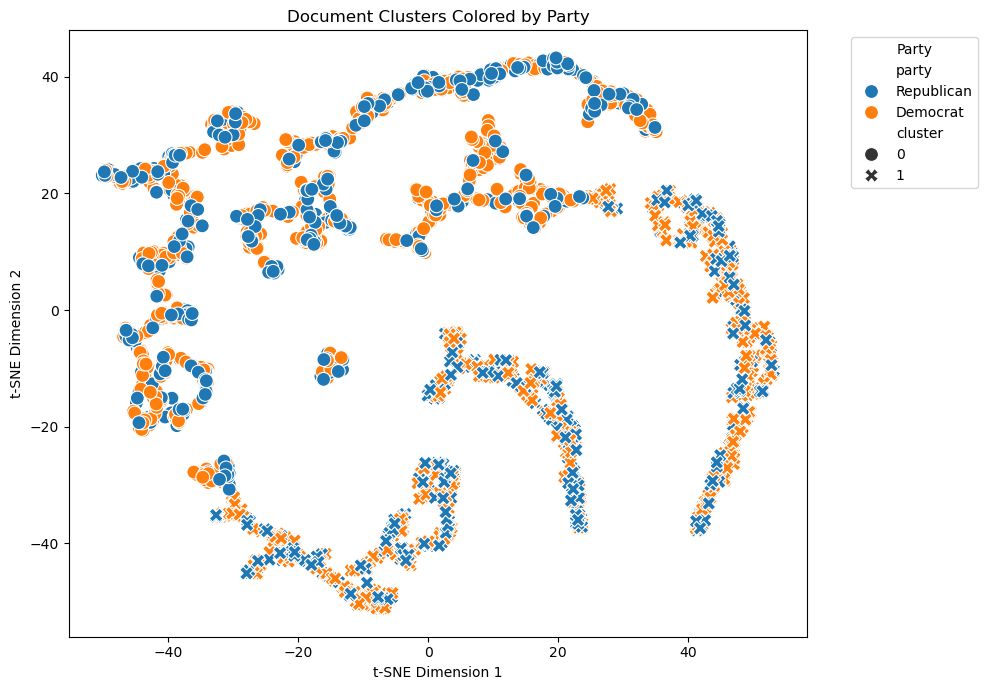

In [161]:
# Step 3: Dimensionality reduction for visualization
tsne = TSNE(n_components=2, random_state=42)
#reduced_embeddings = tsne.fit_transform(reduced_embeddings)

# Step 4: Plot the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=reduced_embeddings[:, 0],
    y=reduced_embeddings[:, 1],
    hue=df['party'],
    style=df['cluster'],
    palette="tab10",
    s=100
)
plt.title("Document Clusters Colored by Party")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Party", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

## Trump Test

In [175]:
docs = df[df['party'] == 'Democrat']['text'][0:2]

In [176]:
trump = get_embedding(list(docs), embedding_type="word", word='Trumps')

In [185]:
def get_similar_words(embedding, model_name="mlburnham/Political_DEBATE_base_v1.0", top_n=10):
    """
    Find the most similar words in the model's vocabulary to a given embedding.

    Args:
        embedding (torch.Tensor): The input embedding to compare against the vocabulary.
        model_name (str): The name of the transformer model.
        top_n (int): The number of most similar words to return.

    Returns:
        list: The top N most similar words.
    """
    # Initialize the tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    model.to(device)
    
    # Get vocabulary tokens
    vocab_tokens = list(tokenizer.get_vocab().keys())
    
    # Generate embeddings for all vocabulary tokens
    token_embeddings = []
    batch_size = 512  # Process vocabulary in batches to save memory
    for i in range(0, len(vocab_tokens), batch_size):
        batch_tokens = vocab_tokens[i:i+batch_size]
        inputs = tokenizer(batch_tokens, return_tensors="pt", padding=True, truncation=True, max_length=1).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        # Take the CLS token's embedding for each token in the batch
        batch_embeddings = outputs.last_hidden_state[:, 0, :]  # Shape: (batch_size, embedding_dim)
        token_embeddings.append(batch_embeddings)
    token_embeddings = torch.cat(token_embeddings, dim=0)  # Shape: (vocab_size, embedding_dim)
    
    # Calculate cosine similarity between the input embedding and token embeddings
    embedding = embedding.unsqueeze(0).to(device)  # Shape: (1, embedding_dim)
    token_embeddings = token_embeddings.to(device)
    similarities = cosine_similarity(embedding.cpu().numpy(), token_embeddings.cpu().numpy()).flatten()
    
    # Find the top N most similar words
    top_indices = np.argsort(similarities)[::-1][:top_n]
    top_words = [vocab_tokens[i] for i in top_indices]
    
    return top_words


In [182]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

find_similar_words(df[0:3], model_name="mlburnham/Political_DEBATE_base_v1.0", top_n=10)

/var/folders/1q/xggcl4hn6mx_q8dfxbx_whpr0000gq/T/ipykernel_59694/2210204274.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['similar_words'] = similar_words


,username,text,party,embedding,cluster,similar_words
0,LindseyGrahamSC,I can only imagine if President Trump had done...,Republican,"[tensor(-0.4835, device='mps:0'), tensor(0.108...",1,"[oohoo, 👍, unny, ▁nah, nah, nish, dez, 哈, sure..."
1,SenSchumer,There is a rot at the center of the modern Rep...,Democrat,"[tensor(0.1718, device='mps:0'), tensor(-0.101...",1,"[▁Neutral, Neutral, ▁neutral, neutral, ▁indiff..."
2,SenatorLeahy,Statement of Chairman Leahy On Reevaluating Tr...,Democrat,"[tensor(-0.2181, device='mps:0'), tensor(0.432...",0,"[⠀, ‧, 》, ▾, (, ▁(, です, 👇, 〕, ።]"


In [186]:
get_similar_words(trump[0])

['lach',
 'ragh',
 '▁impartial',
 'uum',
 'eesh',
 'oop',
 'handedly',
 '▁gladly',
 '▁wisely',
 '▁political']